In [1]:
import os
import xarray as xr
import sys
import itertools
from itertools import zip_longest
from lca_algebraic import initProject
import pandas as pd
import numpy as np
import xarray as xr
import pickle 

In [2]:
def BEV_howtodsfillna_perTRL (data, sel_ds, unionindex, tt, ss, yy): 
    v_module = sel_ds['v_module'].values
    """ naming problems in data_TRL and here result ds not matched """ 
    if tt == 'grid': 
        tt = 'grid_elec'
    elif tt == 'onsite100PV': 
        tt = 'REC_100PV'
    elif tt == 'LFP':
        tt = 'LIB_LFP'
    elif tt == 'LTO':
        tt = 'LIB_LTO'
    elif tt == 'NCA':
        tt = 'LIB_NCA'
    elif tt == 'NMC622':
        tt = 'LIB_NMC622'
 
    """ there're two cases: 
            1.fill_value DO NOT set to 0 (using nan) if it's due to TRL not ready, so it wont be summed later on, 
            2.fill value = 0, if it's because the TOD is not spanning through the whole LCI + THI for each module, 
                e.g., module F2 has 0 as Y[0], then span through Y[1] upto Y[119];  module V1+V1 has Y[0] up to Y[99]  
    """  
    # data_sel = data.sel(Tech = tt, SSP = ss, v_year= yy, size = 'HDV_class7', v_type = 'garbage_truck', powertrain = 'BEV' )  
    """ special case for Bat_replacement, for a certain vy, retrieve vy+10 TRL, unless its 2050 already, bat_TRL use 2050 value """  
    if 'V1B' in str(v_module) and 'V1A' not in str(v_module): 
        if 2050 in sel_ds['v_year'].values:
            data_sel = data.sel(Tech = tt, SSP = ss, v_year= yy, size = 'HDV_class7', v_type = 'garbage_truck', powertrain = 'BEV' )
        else: 
            data_sel = data.sel(Tech = tt, SSP = ss, v_year= yy + 10 , size = 'HDV_class7', v_type = 'garbage_truck', powertrain = 'BEV' )
    else: 
        data_sel = data.sel(Tech = tt, SSP = ss, v_year= yy, size = 'HDV_class7', v_type = 'garbage_truck', powertrain = 'BEV' ) 
     
    if 1 in data_sel['tech_avail'].values :
        f_ds = sel_ds.reindex(lcia_year=unionindex, fill_value=0)
    else:
        f_ds = sel_ds.reindex(lcia_year=unionindex, fill_value=np.nan)
        
    return(f_ds) 

### 1. get prepared lcia_ for each module

In [3]:
data = xr.open_dataset( os.path.abspath(os.path.join( '/Users/susierwu/Dropbox/DLCA_DynCO2/pdpLCA_GT/', 'data/to_use_interm/TRL_1C_vehDSwhTRL.nc')))

In [4]:
ds1 = xr.open_dataset('../dlcia_output/V1AB_BEV_initY_dpIRFCRF.nc')
ds2 = xr.open_dataset('../dlcia_output/F2_BEVGT_dpIRFCRF.nc')
ds3 = xr.open_dataset('../dlcia_output/V1B_BEV_Yrepl_dpIRFCRF.nc')

In [5]:
combined_ds = xr.concat([ds1['dplcia'], ds2['dplcia'], ds3['dplcia']], dim='lcia_year')
dscc = combined_ds.to_dataset()

In [6]:
dscc

<xarray.Dataset>
Dimensions:    (ensemble: 1001, tech_list: 7, SSP: 3, dpLCA_IC: 3, v_year: 3,
                v_module: 3, lcia_year: 322)
Coordinates:
  * ensemble   (ensemble) int32 0 1 2 3 4 5 6 7 ... 994 995 996 997 998 999 1000
  * tech_list  (tech_list) object 'LFP' 'LSB' 'LTO' ... 'grid' 'onsite100PV'
  * SSP        (SSP) object 'ssp119' 'ssp245' 'ssp585'
  * dpLCA_IC   (dpLCA_IC) object 'dpIRF' 'dpCRF' 'dpGWP'
  * v_year     (v_year) int32 2030 2040 2050
  * v_module   (v_module) object 'F2_fuel_elec' 'V1A_V1B_init' 'V1B_repl'
  * lcia_year  (lcia_year) int32 0 1 2 3 4 5 6 7 ... 104 105 106 107 108 109 110
Data variables:
    dplcia     (SSP, v_year, v_module, tech_list, lcia_year, dpLCA_IC, ensemble) float64 ...

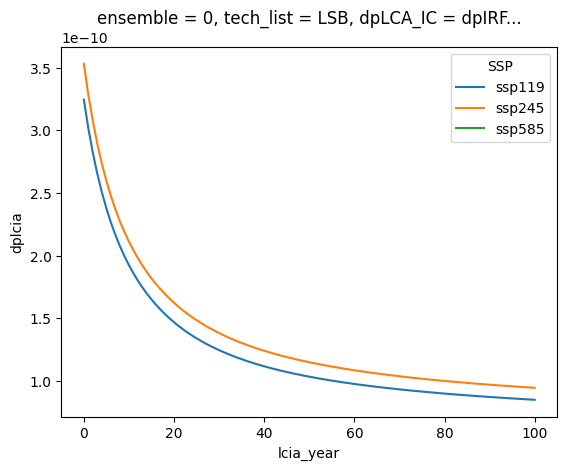

In [7]:
dscc.sel(tech_list = "LSB", v_year = 2040, ensemble = 0, dpLCA_IC = 'dpIRF', v_module = 'V1A_V1B_init')['dplcia'].plot(x = "lcia_year", hue = "SSP");

## 2. to create a final ds to get all vehicle_module impact (per user-defined mod/tech combination)

In [8]:
""" empty result ds, to combine final vehicle cycle from diff modules, so no v_module in this ds """
ssp, v_year, dpLCA_IC = dscc["SSP"].values, dscc["v_year"].values, dscc["dpLCA_IC"].values
lcia_year = np.array(ds1.indexes['lcia_year'].union(ds2.indexes['lcia_year']).union(ds3.indexes['lcia_year']) )
# Create a new xarray dataset with dimensions
ds = xr.Dataset(coords={'SSP':  ssp, 'v_year': v_year, 'dpLCA_IC': dpLCA_IC, 'lcia_year': lcia_year,   })
empty_data_array = xr.DataArray(np.nan, coords=ds.coords, dims=ds.dims)
ds['dplcia'] = empty_data_array
#ds

### 2.A user-defined tech

In [9]:
ssp, v_year, dpLCA_IC = dscc["SSP"].values, dscc["v_year"].values, dscc["dpLCA_IC"].values
lcia_year = np.array(ds1.indexes['lcia_year'].union(ds2.indexes['lcia_year']).union(ds3.indexes['lcia_year']) )
# Create a new xarray dataset with dimensions
ds = xr.Dataset(coords={'SSP':  ssp, 'v_year': v_year, 'dpLCA_IC': dpLCA_IC, 'lcia_year': lcia_year,   })
empty_data_array = xr.DataArray(np.nan, coords=ds.coords, dims=ds.dims)
ds['dplcia'] = empty_data_array

""" need a pre-defined dict for selecting one tech for each module """ 
tech_toget_formod = {'V1A_V1B_init' :'LFP',
                     'F2_fuel_elec': 'grid', 
                     'V1B_repl' :'LSB',
                     }

for vy in dscc["v_year"].values: 
    for sp in dscc["SSP"].values: 
        v1mod_toget, v2mod_toget, v3mod_toget = list(tech_toget_formod.keys())[0], list(tech_toget_formod.keys())[1], list(tech_toget_formod.keys())[2]
        
        sel_ds1 = dscc.sel(v_year = vy, SSP = sp, v_module = v1mod_toget, dpLCA_IC = 'dpIRF',
                           tech_list = tech_toget_formod[v1mod_toget], ensemble = 0  ) 
        sel_ds2 = dscc.sel(v_year = vy, SSP = sp, v_module = v2mod_toget, dpLCA_IC = 'dpIRF',
                           tech_list = tech_toget_formod[v2mod_toget], ensemble = 0  )
        sel_ds3 = dscc.sel(v_year = vy, SSP = sp, v_module = v3mod_toget, dpLCA_IC = 'dpIRF',
                           tech_list = tech_toget_formod[v3mod_toget], ensemble = 0  )
        """ above three ds has lcia_year index up to 319, all combined, now filter to get only its related lcia_year 
             e.g., for sel_ds33 for bat_replacement now has correct lcia_year for Y[10] - Y[109]  """ 
        sel_ds11 = sel_ds1.where(sel_ds1['dplcia'].notnull() , drop = True)
        sel_ds22 = sel_ds2.where(sel_ds2['dplcia'].notnull() , drop = True) 
        sel_ds33 = sel_ds3.where(sel_ds3['dplcia'].notnull() , drop = True)
        unionindex = sel_ds11.indexes['lcia_year'].union(sel_ds22.indexes['lcia_year']).union(sel_ds33.indexes['lcia_year'])
        """ there're two cases, served by BEV_howtodsfillna_perTRL() 
        1.fill_value DO NOT set to 0 (using nan) if it's due to TRL not ready, so it wont be summed later on, 
        2.fill value = 0, if it's because the TOD is not spanning through the whole LCI + THI for each module, 
            e.g., module F2 has 0 as Y[0], then span through Y[1] upto Y[119];  module V1+V1 has Y[0] up to Y[99]  
        """  
        # for V1A_V1B init, you always have sth so give 0 to Y[100] - Y[119]
        """ also, do not assign 0 to CRF score, for future non-assessed years here, use np.cumsum(), once irf is prepared """ 
        sel_ds111 = sel_ds11.reindex(lcia_year=unionindex, fill_value= 0 )
        tt2, ss2, yy2 = sel_ds22['tech_list'].values, sel_ds22['SSP'].values, sel_ds22['v_year'].values
        sel_ds222 = BEV_howtodsfillna_perTRL(data, sel_ds22, unionindex, tt2, ss2, yy2 )
        """ special case for Bat_replacement, for a certain vy, retrieve vy+10 TRL  """  
        tt3, ss3, yy3 = sel_ds33['tech_list'].values, sel_ds33['SSP'].values, sel_ds33['v_year'].values
        sel_ds333 = BEV_howtodsfillna_perTRL(data, sel_ds33, unionindex, tt3, ss3, yy3 )
        
        #print(sel_ds111.coords , sel_ds222.coords ,sel_ds333.coords)
        #allds = sel_ds222 + sel_ds111 + sel_ds333
        irfscore = sel_ds111['dplcia'].values + sel_ds222['dplcia'].values + sel_ds333['dplcia'].values
        crfscore = np.cumsum(irfscore)
        
        """ for certain tech_mod, not available under certain SSP / Year """
        alen = ds['dplcia'].loc[{'SSP':sp, 'v_year': vy ,  'dpLCA_IC': 'dpIRF' }].indexes.dims.get('lcia_year') 
        if len(irfscore) == alen: 
            ds['dplcia'].loc[{'SSP':sp, 'v_year': vy, 'dpLCA_IC' : 'dpIRF'}] = irfscore
            ds['dplcia'].loc[{'SSP':sp, 'v_year': vy, 'dpLCA_IC' : 'dpCRF'}] = crfscore
             
        else: 
            print(f" dpLCIA score not assigned to ds, diff dim, some tech not available under SSP {sp}, v_year {vy}")


#### plotting

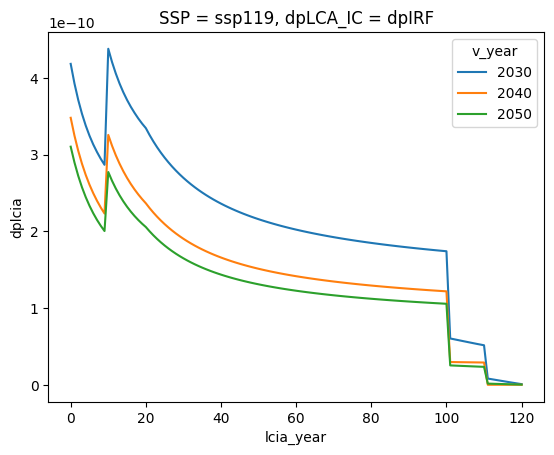

In [10]:
ds.sel(SSP = 'ssp119' , dpLCA_IC =  'dpIRF' )['dplcia'].plot(x = 'lcia_year', hue = 'v_year' );

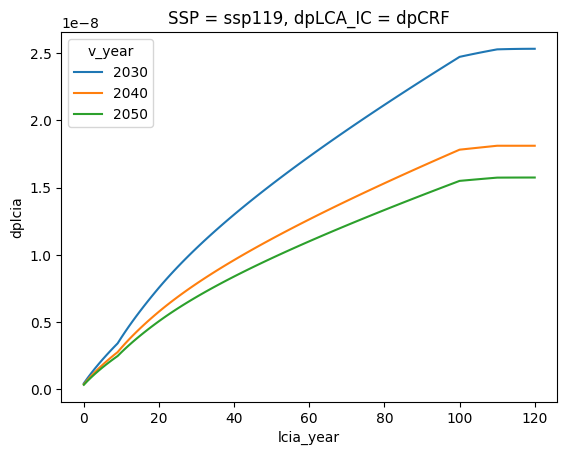

In [11]:
ds.sel(SSP = 'ssp119' , dpLCA_IC =  'dpCRF' )['dplcia'].plot(x = 'lcia_year', hue = 'v_year' );

### 2.B  looping through ALL tech for each module to sum over final vehicle_cycle impacts 

#### 2.B.1 how you can build up vehicle through diff mod/tech combination

In [12]:
all_tech_toget_formod = {'V1A_V1B_init': ['LFP', 'LSB', 'LTO', 'NCA', 'NMC622'],
                         'F2_fuel_elec': ['grid', 'onsite100PV'], 
                         'V1B_repl' : ['LFP', 'LSB', 'LTO', 'NCA', 'NMC622'],
                     }
combinations = list(itertools.product(*all_tech_toget_formod.values()))
each_tech_toget_formod = [{key: value for key, value in zip(all_tech_toget_formod.keys(), combination)} for combination in combinations]
print(len(each_tech_toget_formod))
each_tech_toget_formod

50


[{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LFP'},
 {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'},
 {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'},
 {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'},
 {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'},
 {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'},
 {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'},
 {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'},
 {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'},
 {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'},
 {'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LFP'},
 {'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'},
 {'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'},
 {'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'grid', 'V1B_repl': '

#### 2.B.2 build up final ds for each mod/tech comb

In [13]:
final_alltech_list = []
for tech_toget_formod in each_tech_toget_formod: 
    """ create empty ds for each mod_tech loop""" 
    ssp, v_year, dpLCA_IC = dscc["SSP"].values, dscc["v_year"].values, dscc["dpLCA_IC"].values
    lcia_year = np.array(ds1.indexes['lcia_year'].union(ds2.indexes['lcia_year']).union(ds3.indexes['lcia_year']) )
    # Create a new xarray dataset with dimensions
    ds = xr.Dataset(coords={'SSP':  ssp, 'v_year': v_year, 'dpLCA_IC': dpLCA_IC, 'lcia_year': lcia_year,   })
    empty_data_array = xr.DataArray(np.nan, coords=ds.coords, dims=ds.dims)
    ds['dplcia'] = empty_data_array
    
    allSSPMYlist = [] 
    for vy in dscc["v_year"].values: 
        for sp in dscc["SSP"].values: 
            v1mod_toget, v2mod_toget, v3mod_toget = list(tech_toget_formod.keys())[0], list(tech_toget_formod.keys())[1], list(tech_toget_formod.keys())[2]
            
            sel_ds1 = dscc.sel(v_year = vy, SSP = sp, v_module = v1mod_toget, dpLCA_IC = 'dpIRF',
                               tech_list = tech_toget_formod[v1mod_toget], ensemble = 0  ) 
            sel_ds2 = dscc.sel(v_year = vy, SSP = sp, v_module = v2mod_toget, dpLCA_IC = 'dpIRF',
                               tech_list = tech_toget_formod[v2mod_toget], ensemble = 0  )
            sel_ds3 = dscc.sel(v_year = vy, SSP = sp, v_module = v3mod_toget, dpLCA_IC = 'dpIRF',
                               tech_list = tech_toget_formod[v3mod_toget], ensemble = 0  )
            """ above three ds has lcia_year index up to 319, all combined, now filter to get only its related lcia_year 
                 e.g., for sel_ds33 for bat_replacement now has correct lcia_year for Y[10] - Y[109]  """ 
            sel_ds11 = sel_ds1.where(sel_ds1['dplcia'].notnull() , drop = True)
            sel_ds22 = sel_ds2.where(sel_ds2['dplcia'].notnull() , drop = True) 
            sel_ds33 = sel_ds3.where(sel_ds3['dplcia'].notnull() , drop = True)
            unionindex = sel_ds11.indexes['lcia_year'].union(sel_ds22.indexes['lcia_year']).union(sel_ds33.indexes['lcia_year'])
            """ there're two cases, served by BEV_howtodsfillna_perTRL() 
            1.fill_value DO NOT set to 0 (using nan) if it's due to TRL not ready, so it wont be summed later on, 
            2.fill value = 0, if it's because the TOD is not spanning through the whole LCI + THI for each module, 
                e.g., module F2 has 0 as Y[0], then span through Y[1] upto Y[119];  module V1+V1 has Y[0] up to Y[99]  
            """  
            # for V1A_V1B init, you always have sth so give 0 to Y[100] - Y[119]
            """ also, do not assign 0 to CRF score, for future non-assessed years here, use np.cumsum(), once irf is prepared """ 
            sel_ds111 = sel_ds11.reindex(lcia_year=unionindex, fill_value= 0 )
            tt2, ss2, yy2 = sel_ds22['tech_list'].values, sel_ds22['SSP'].values, sel_ds22['v_year'].values
            sel_ds222 = BEV_howtodsfillna_perTRL(data, sel_ds22, unionindex, tt2, ss2, yy2 )
            tt3, ss3, yy3 = sel_ds33['tech_list'].values, sel_ds33['SSP'].values, sel_ds33['v_year'].values
            sel_ds333 = BEV_howtodsfillna_perTRL(data, sel_ds33, unionindex, tt3, ss3, yy3 )
            
            #print(sel_ds111.coords , sel_ds222.coords ,sel_ds333.coords)
            #allds = sel_ds222 + sel_ds111 + sel_ds333
            irfscore = sel_ds111['dplcia'].values + sel_ds222['dplcia'].values + sel_ds333['dplcia'].values
            crfscore = np.cumsum(irfscore)
            
            """ for certain tech_mod, not available under certain SSP / Year """
            alen = ds['dplcia'].loc[{'SSP':sp, 'v_year': vy ,  'dpLCA_IC': 'dpIRF' }].indexes.dims.get('lcia_year') 
            if len(irfscore) == alen: 
                ds['dplcia'].loc[{'SSP':sp, 'v_year': vy, 'dpLCA_IC' : 'dpIRF'}] = irfscore
                ds['dplcia'].loc[{'SSP':sp, 'v_year': vy, 'dpLCA_IC' : 'dpCRF'}] = crfscore
            else: 
                pass
                print(f" dpLCIA score not assigned to ds, diff dim, some tech not available under SSP {sp}, v_year {vy}")
        
    final_alltech_list.append(ds)

 dpLCIA score not assigned to ds, diff dim, some tech not available under SSP ssp119, v_year 2030
 dpLCIA score not assigned to ds, diff dim, some tech not available under SSP ssp245, v_year 2030
 dpLCIA score not assigned to ds, diff dim, some tech not available under SSP ssp585, v_year 2030
 dpLCIA score not assigned to ds, diff dim, some tech not available under SSP ssp585, v_year 2040
 dpLCIA score not assigned to ds, diff dim, some tech not available under SSP ssp119, v_year 2030
 dpLCIA score not assigned to ds, diff dim, some tech not available under SSP ssp245, v_year 2030
 dpLCIA score not assigned to ds, diff dim, some tech not available under SSP ssp585, v_year 2030
 dpLCIA score not assigned to ds, diff dim, some tech not available under SSP ssp585, v_year 2040
 dpLCIA score not assigned to ds, diff dim, some tech not available under SSP ssp119, v_year 2030
 dpLCIA score not assigned to ds, diff dim, some tech not available under SSP ssp245, v_year 2030
 dpLCIA score not as

In [14]:
len(final_alltech_list)

50

### legend by SSP - select a v_year then plot all it's possible tech_combination to build the vehicle 


{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LFP'}


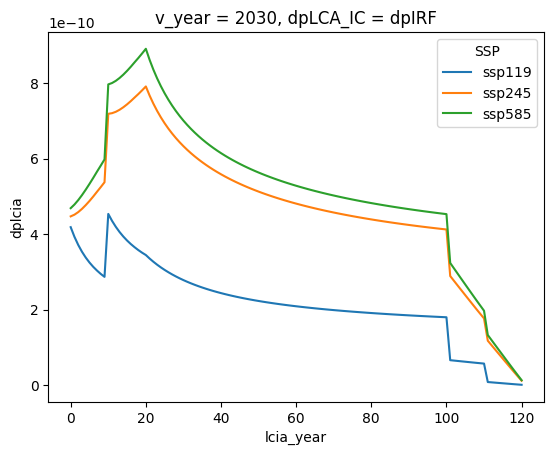

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


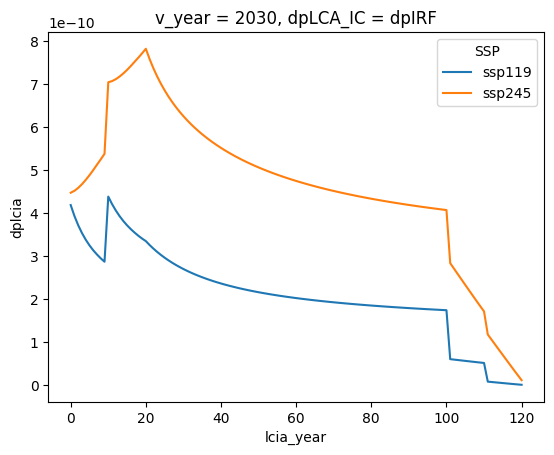

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


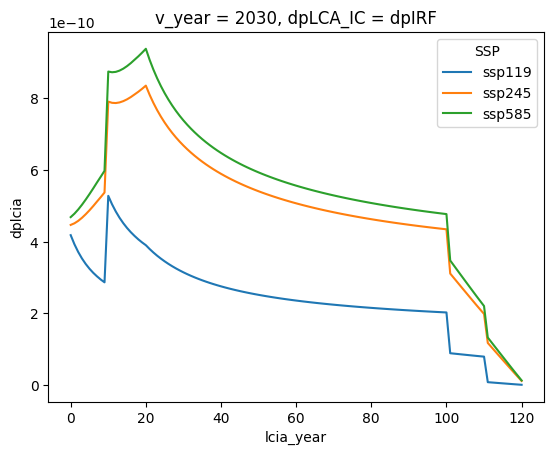

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


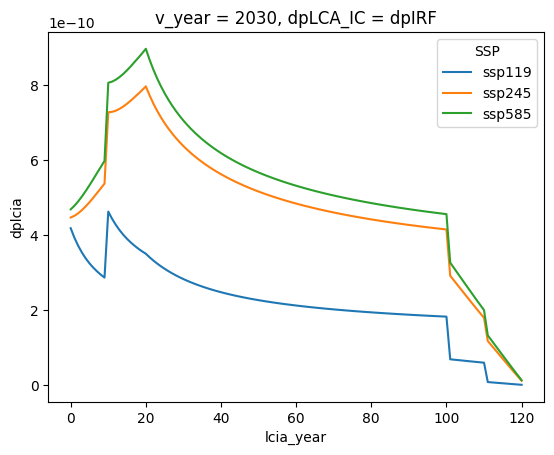

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


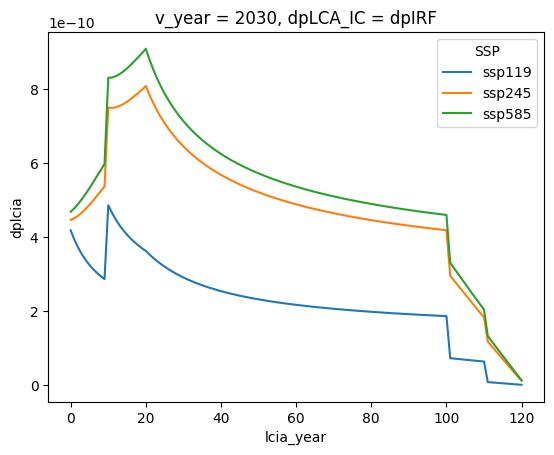

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}
the module/tech_combination is not available under any SSP[x] for {

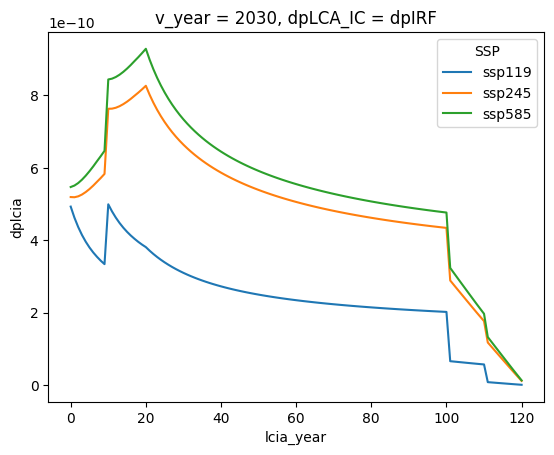

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


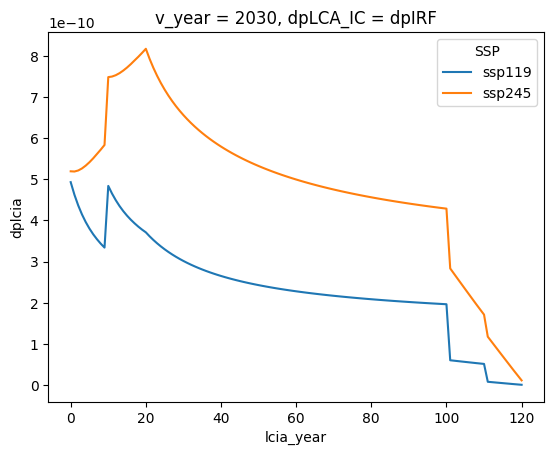

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


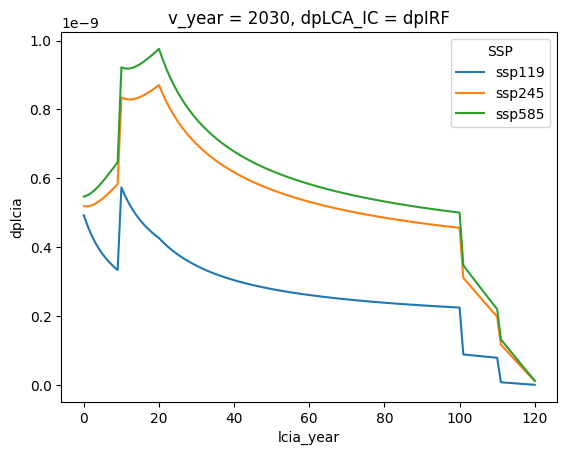

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


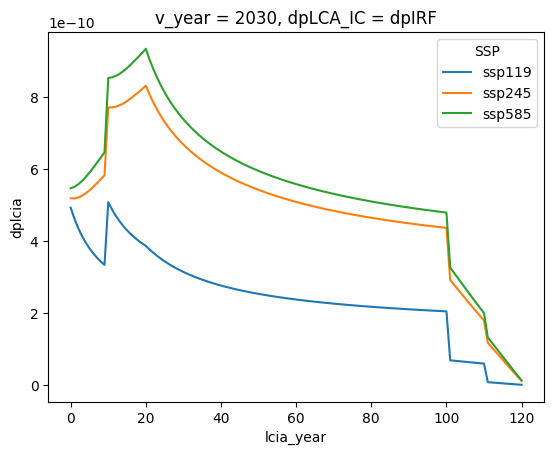

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


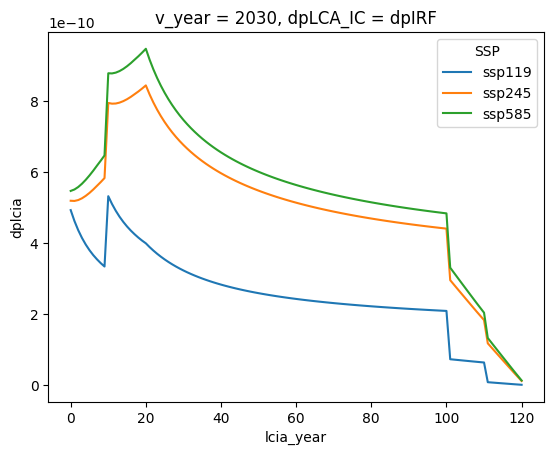

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}
the module/tech_combination is not available under any SSP[x] for {

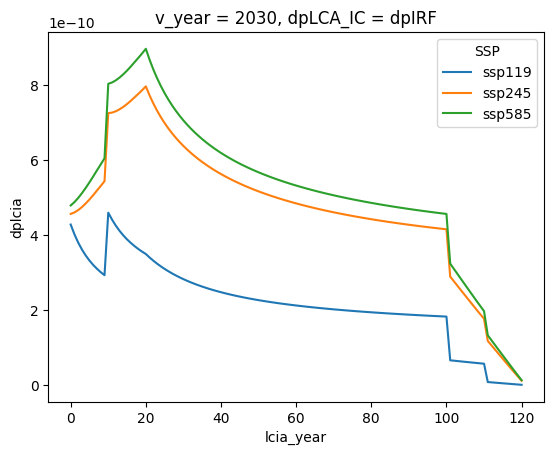

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


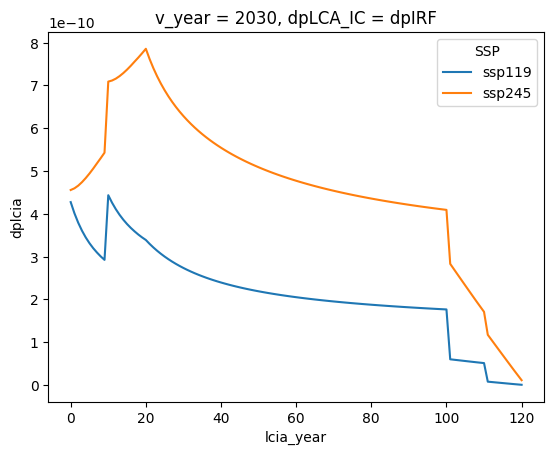

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


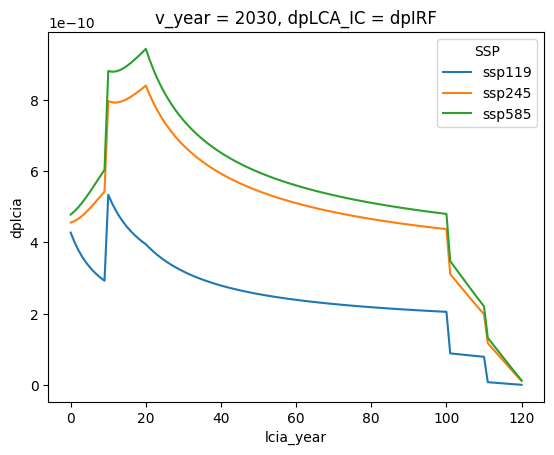

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


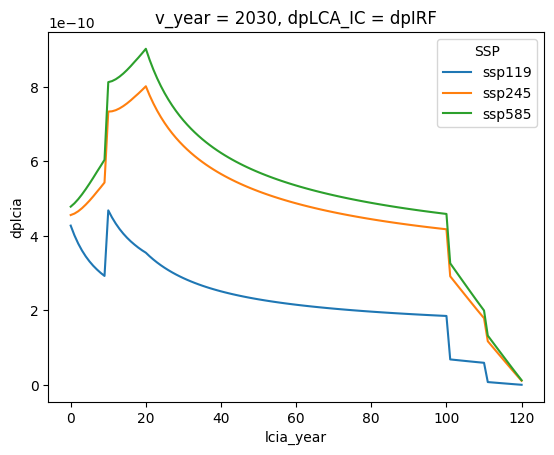

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


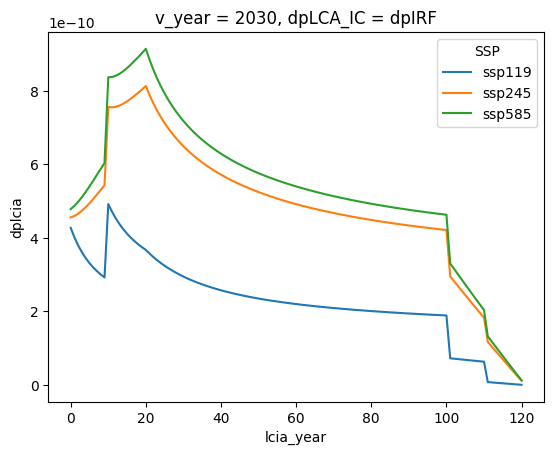

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}
the module/tech_combination is not available under any SSP[x] for {

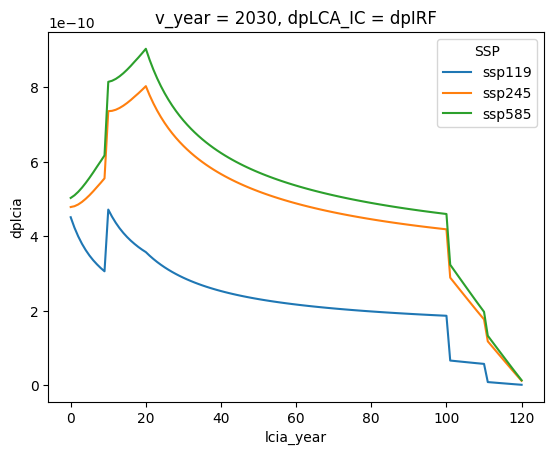

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


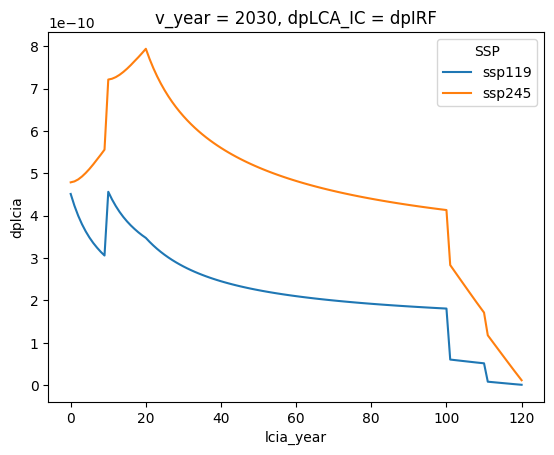

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


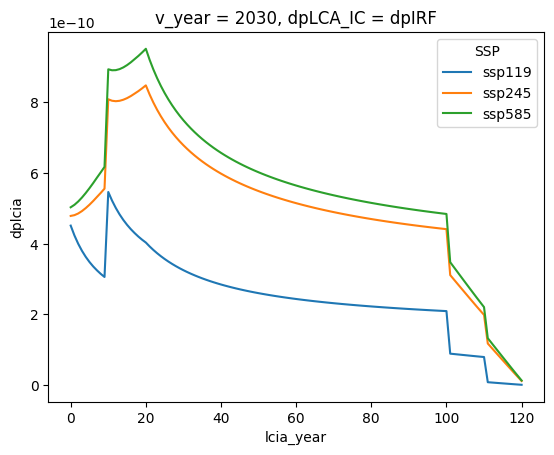

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


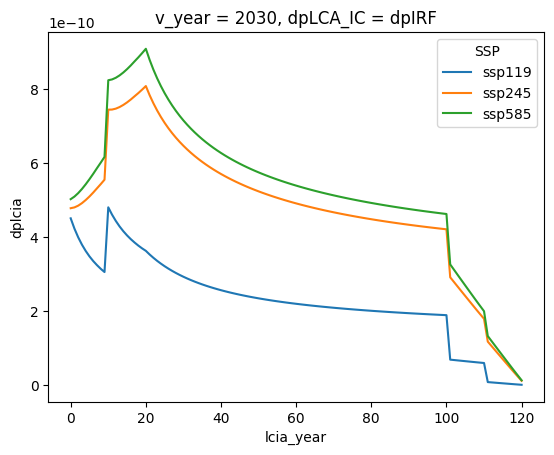

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


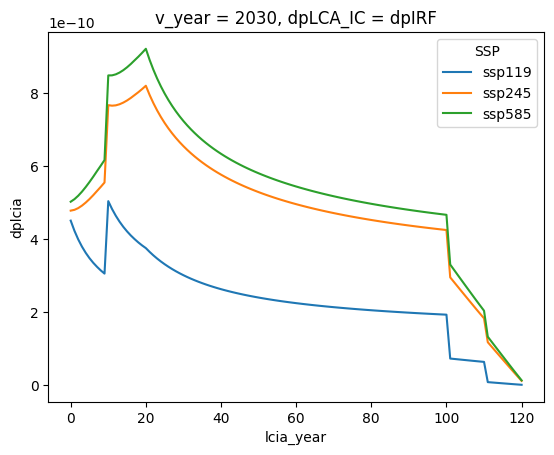

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}
the module/tech_combination is not avail

In [15]:
import matplotlib.pyplot as plt

v_y_toplot = 2030
for i in range(len(final_alltech_list)): 
    print(each_tech_toget_formod[i])
    ds_toget = final_alltech_list[i].sel(v_year = v_y_toplot ,  dpLCA_IC = 'dpIRF') 
    ds_toplot = ds_toget.where(ds_toget['dplcia'].notnull() , drop = True)
    if len(ds_toplot['dplcia']) == 0: 
        print(f"the module/tech_combination is not available under any SSP[x] for {each_tech_toget_formod[i]}")
    else:
        ds_toplot['dplcia'].plot(x = 'lcia_year', hue = 'SSP'  )
        plt.show()

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LFP'}


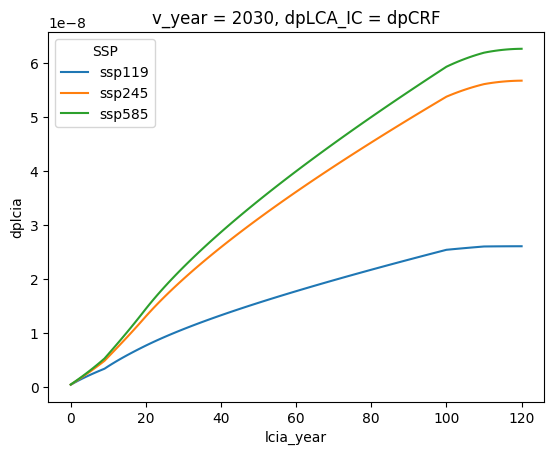

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


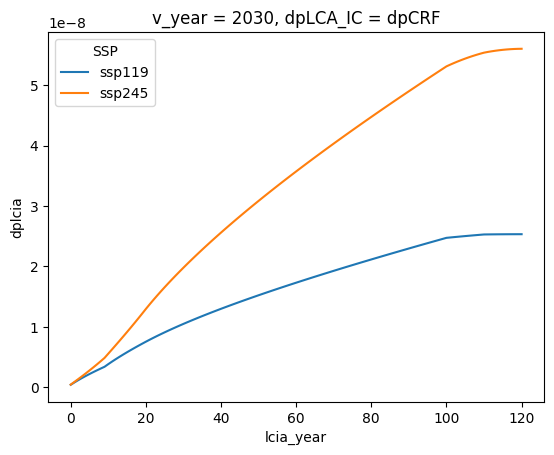

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


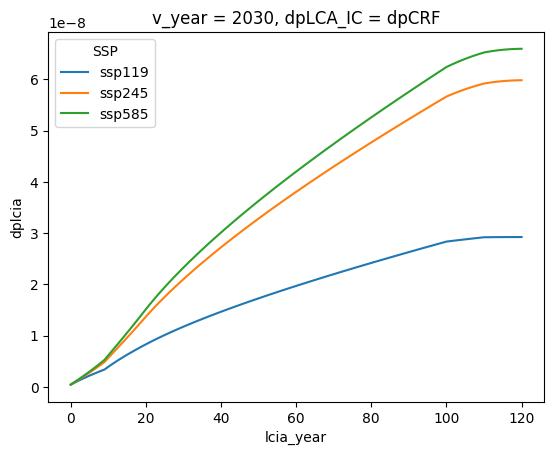

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


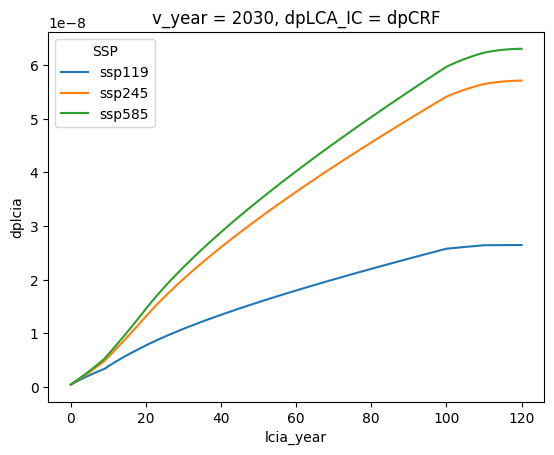

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


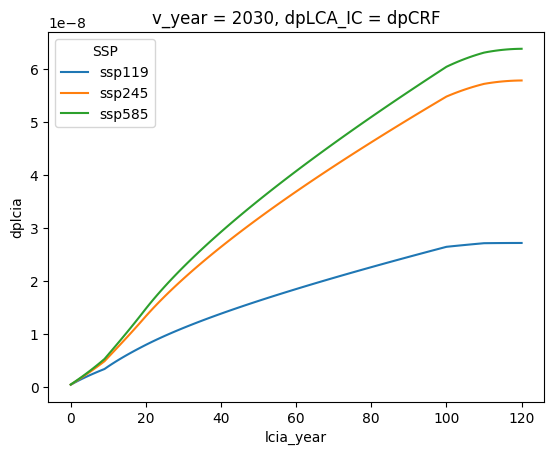

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}
the module/tech_combination is not available under any SSP[x] for {

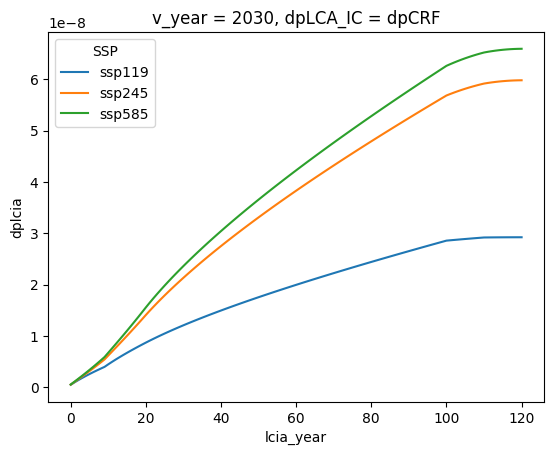

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


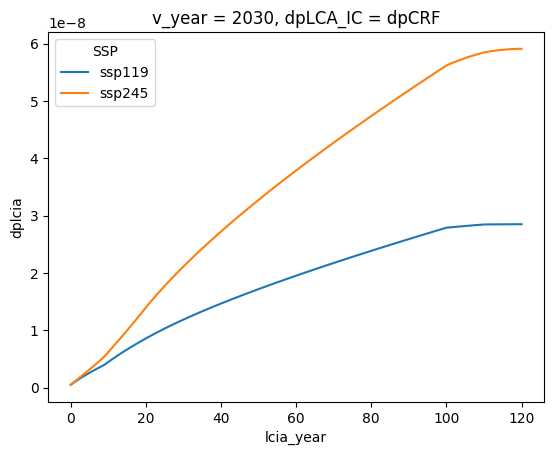

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


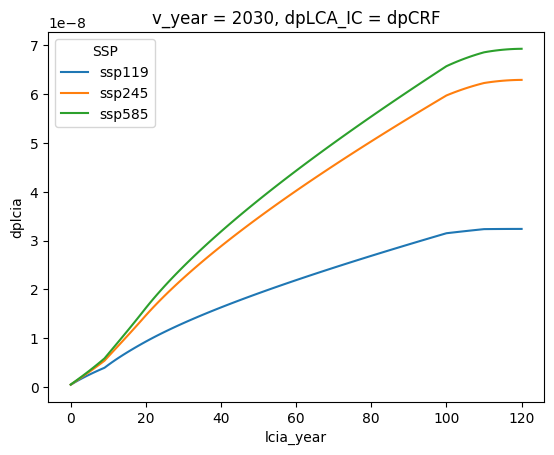

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


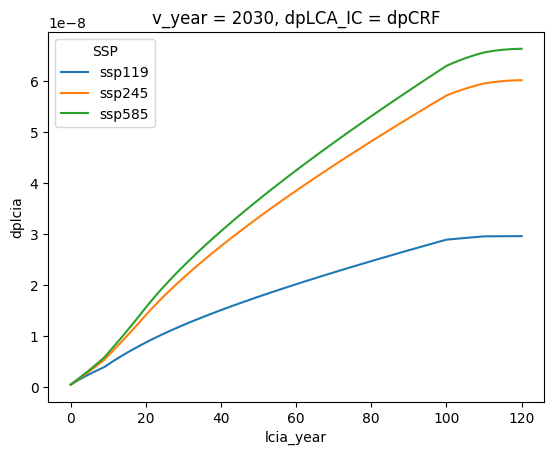

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


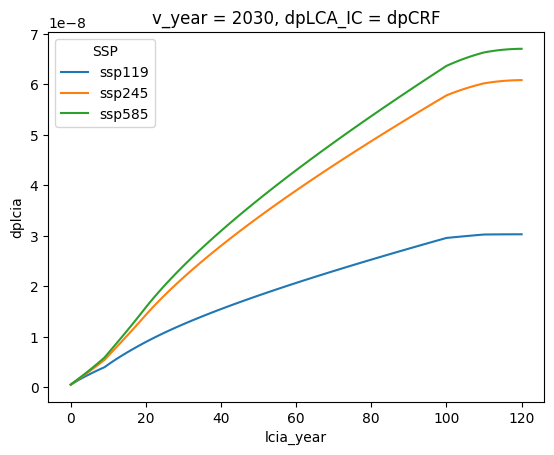

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}
the module/tech_combination is not available under any SSP[x] for {

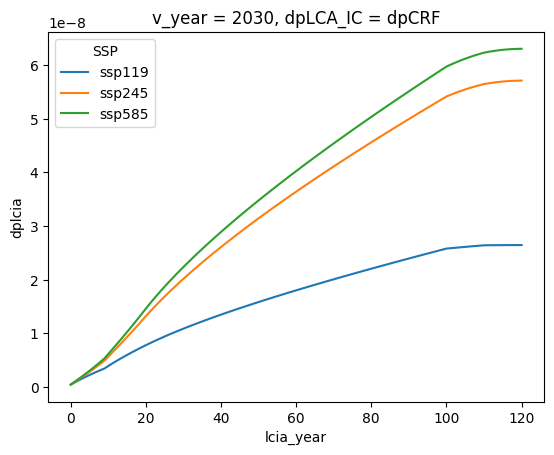

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


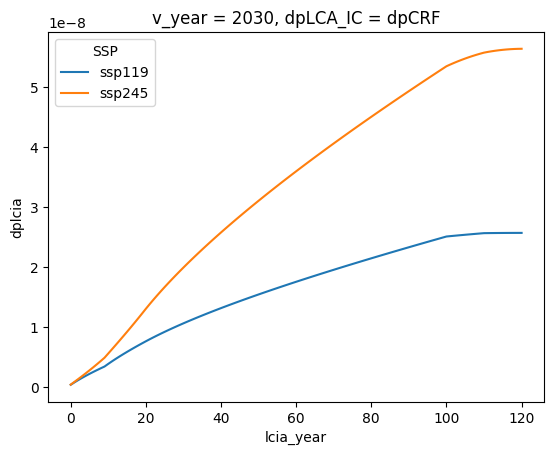

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


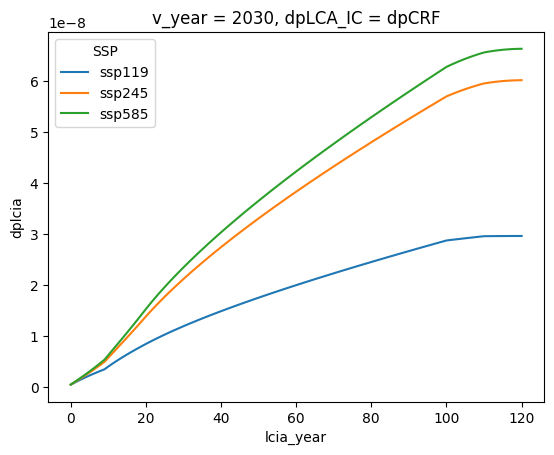

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


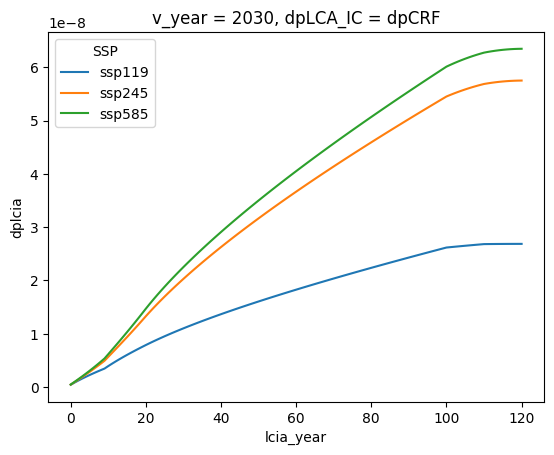

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


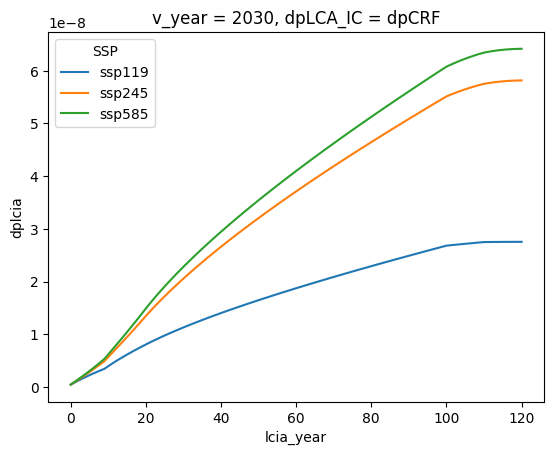

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}
the module/tech_combination is not available under any SSP[x] for {

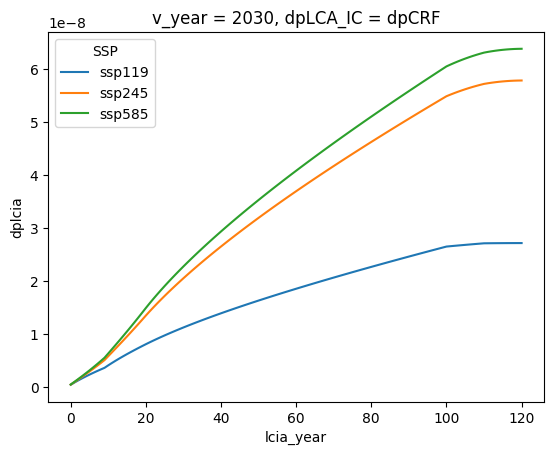

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


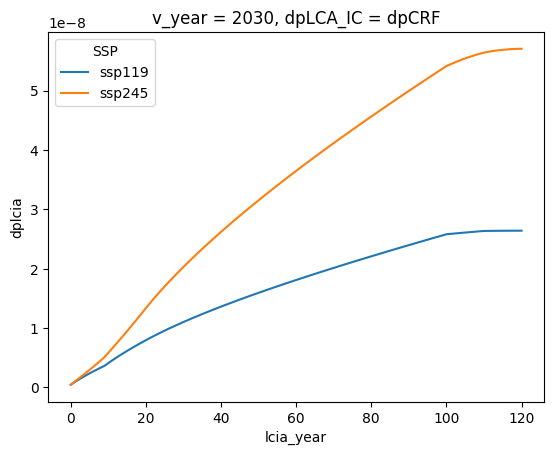

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


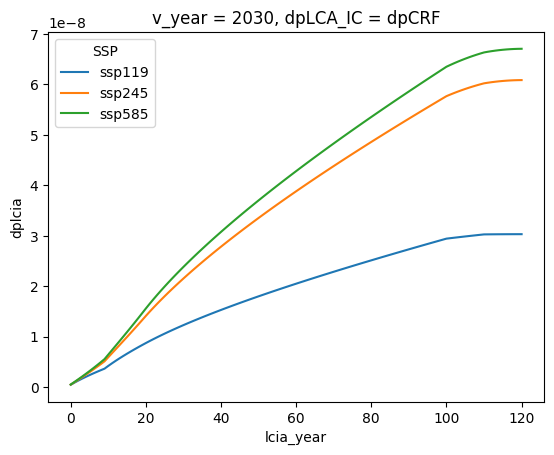

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


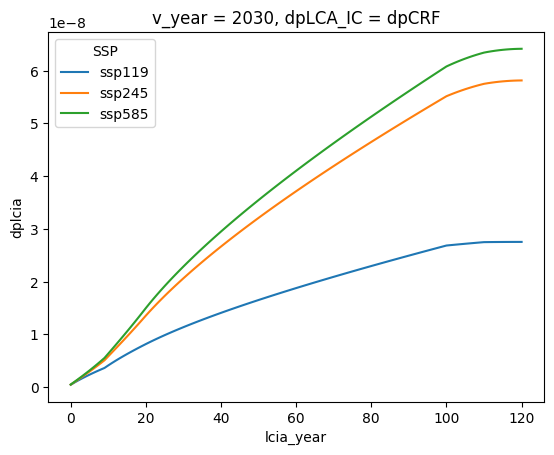

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


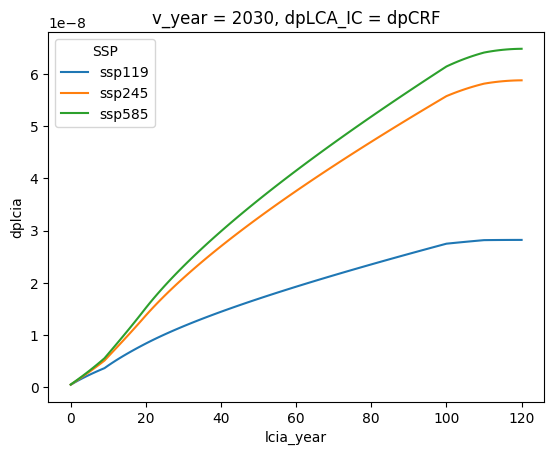

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}
{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}
{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}
{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
the module/tech_combination is not available under any SSP[x] for {'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}
{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}
the module/tech_combination is not avail

In [16]:
v_y_toplot = 2030
for i in range(len(final_alltech_list)): 
    print(each_tech_toget_formod[i])
    ds_toget = final_alltech_list[i].sel(v_year = v_y_toplot,  dpLCA_IC = 'dpCRF') 
    ds_toplot = ds_toget.where(ds_toget['dplcia'].notnull() , drop = True)
    if len(ds_toplot['dplcia']) == 0: 
        print(f"the module/tech_combination is not available under any SSP[x] for {each_tech_toget_formod[i]}")
    else:
        ds_toplot['dplcia'].plot(x = 'lcia_year', hue = 'SSP'  )
        plt.show()

### legend by v_year - select one SSP then plot all it's possible tech_combination for different v_year

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LFP'}


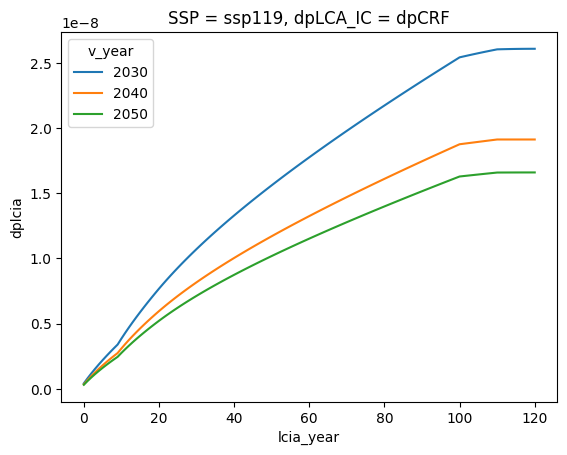

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


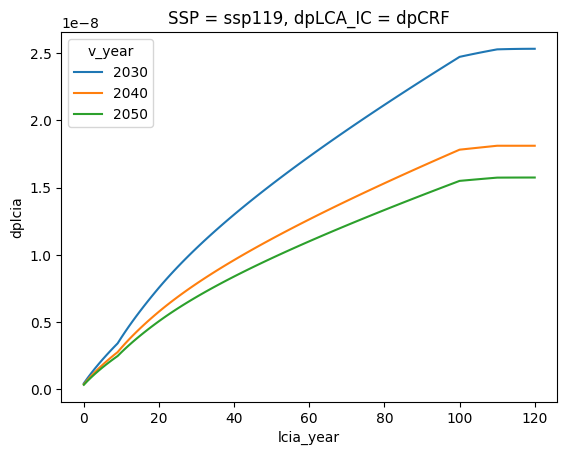

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


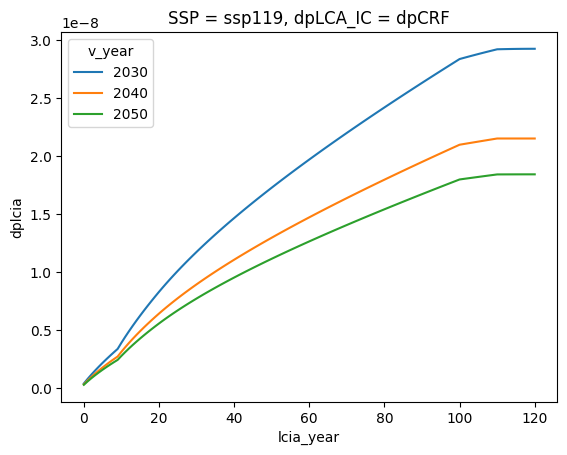

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


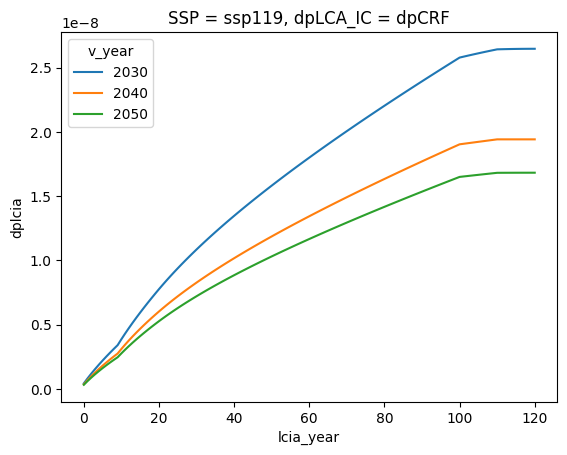

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


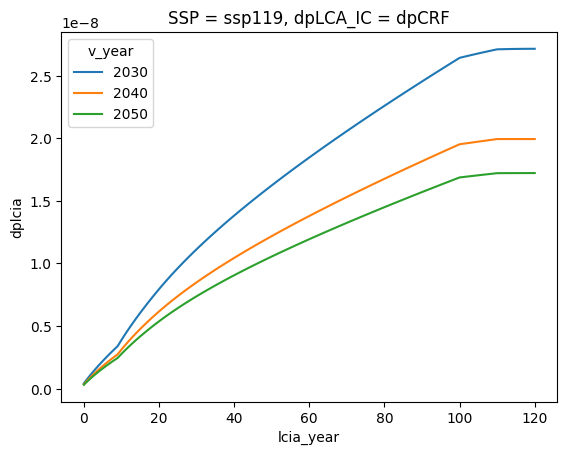

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}


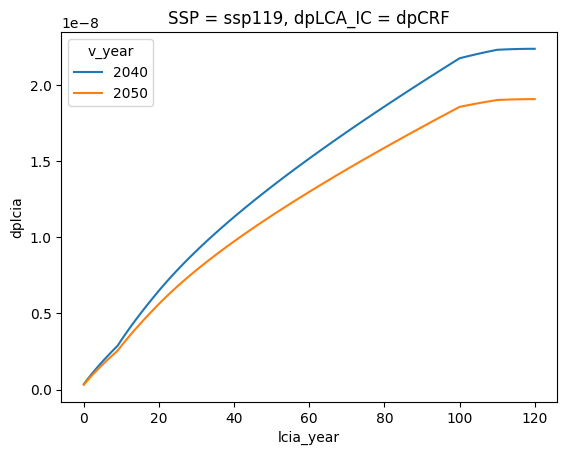

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}


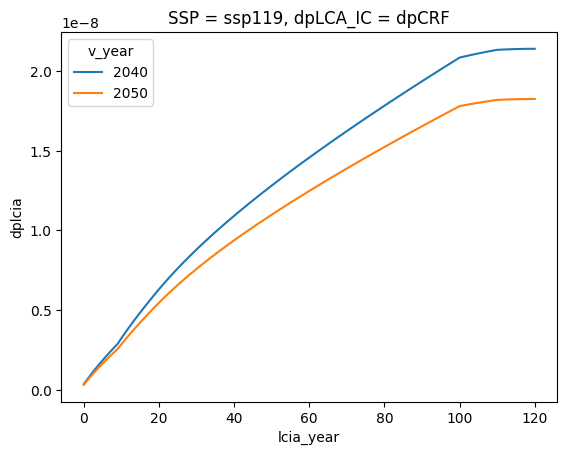

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}


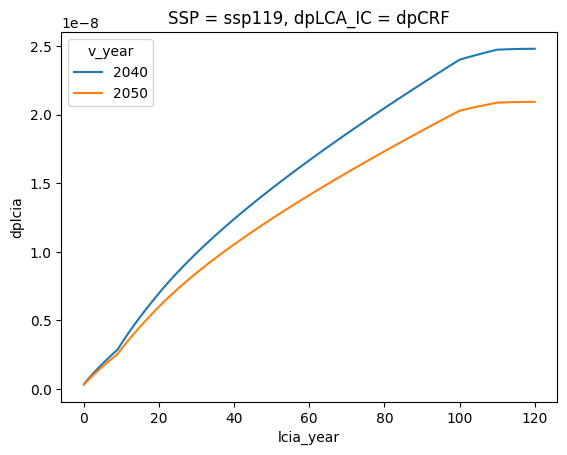

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}


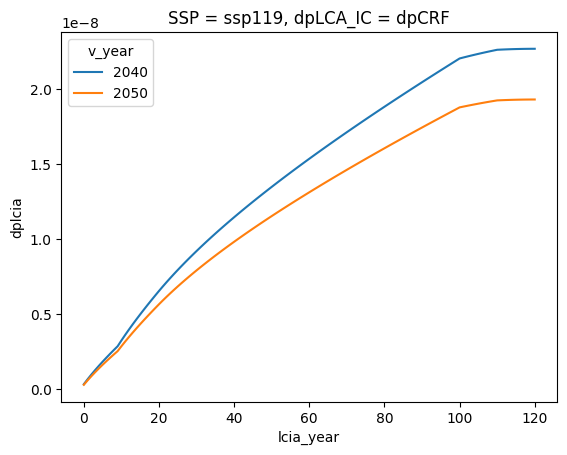

{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}


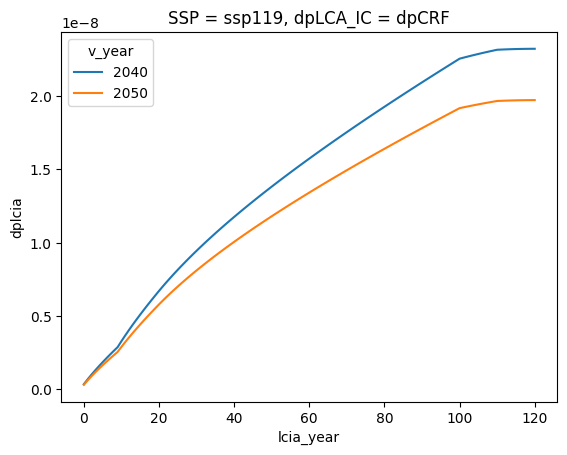

{'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LFP'}


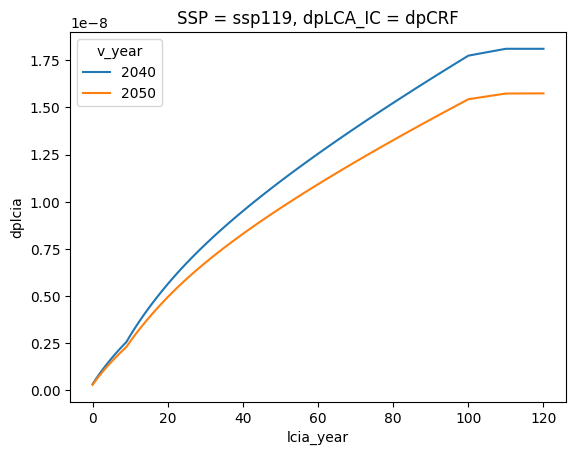

{'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


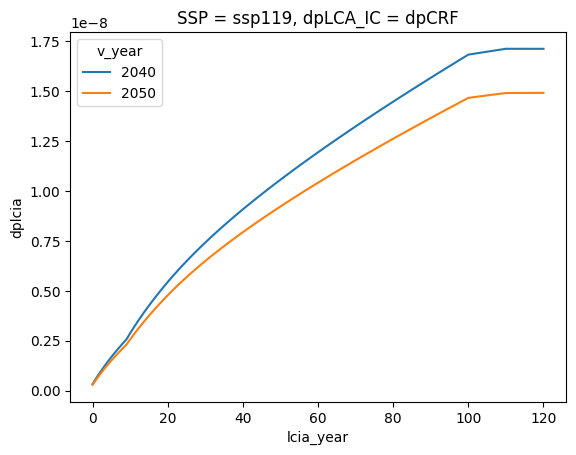

{'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


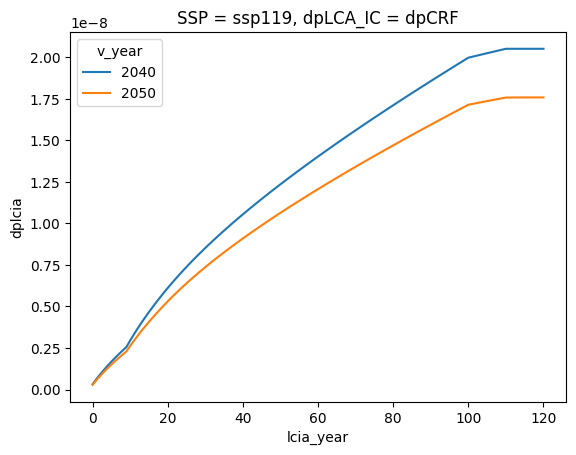

{'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


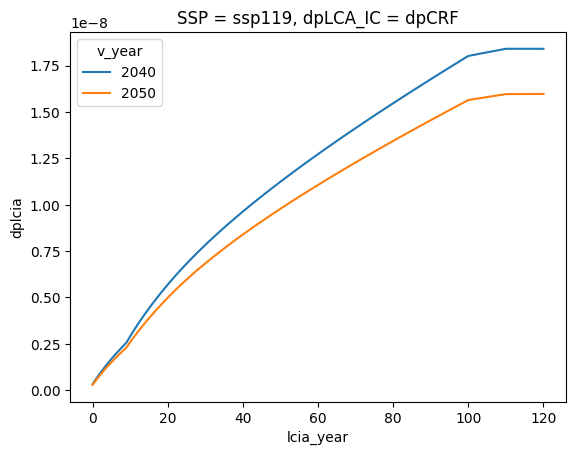

{'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


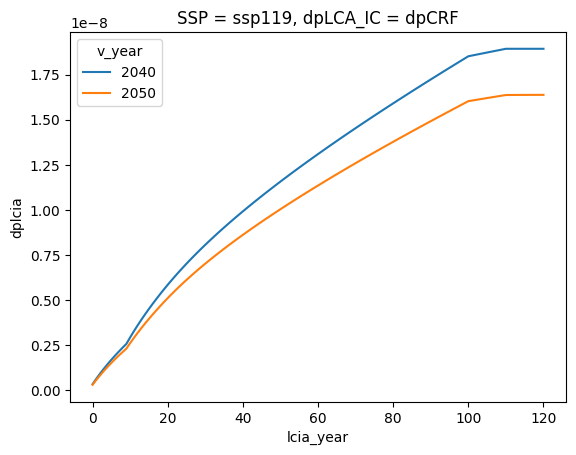

{'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}


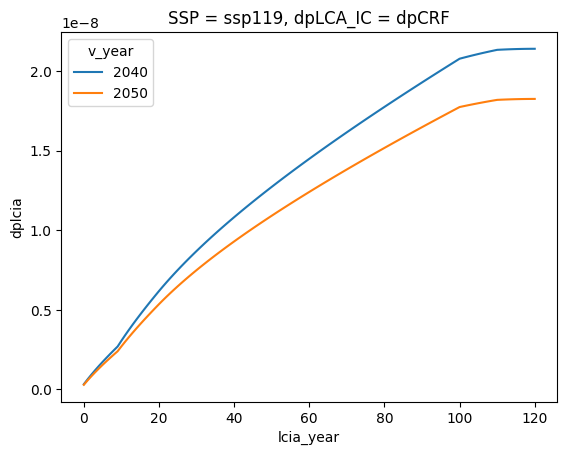

{'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}


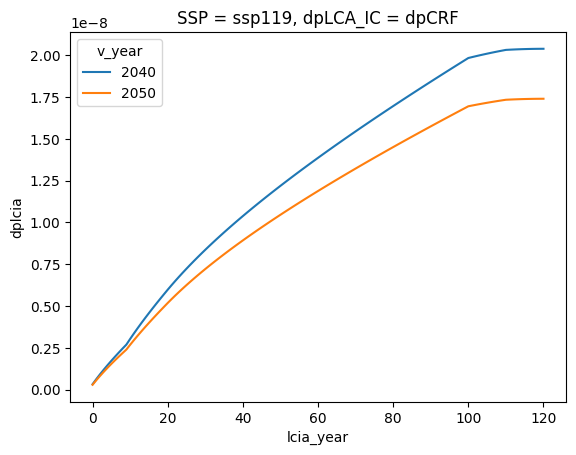

{'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}


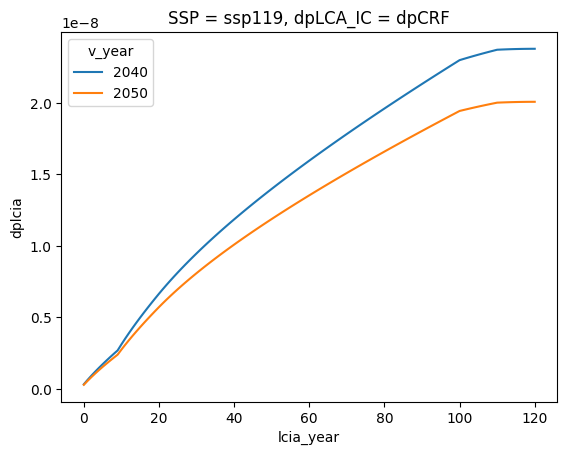

{'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}


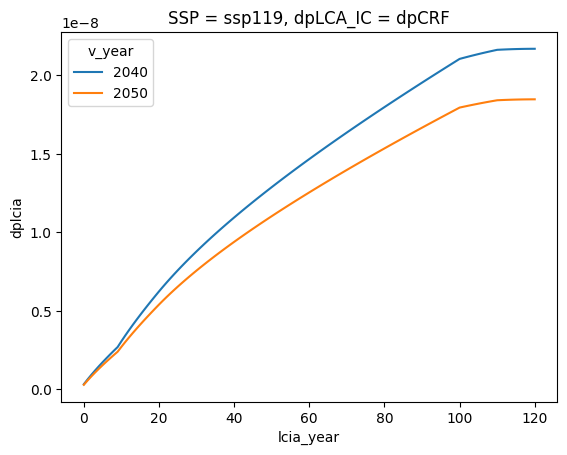

{'V1A_V1B_init': 'LSB', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}


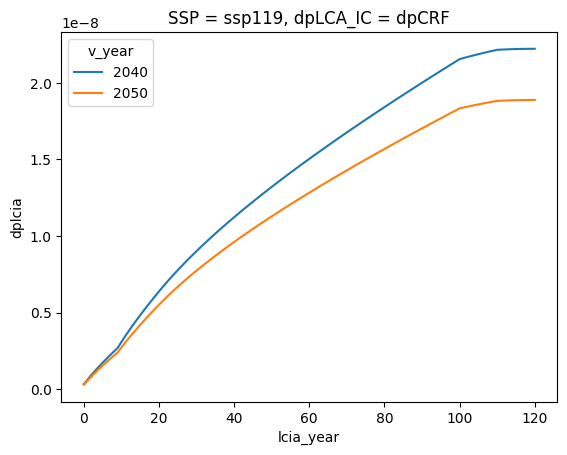

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LFP'}


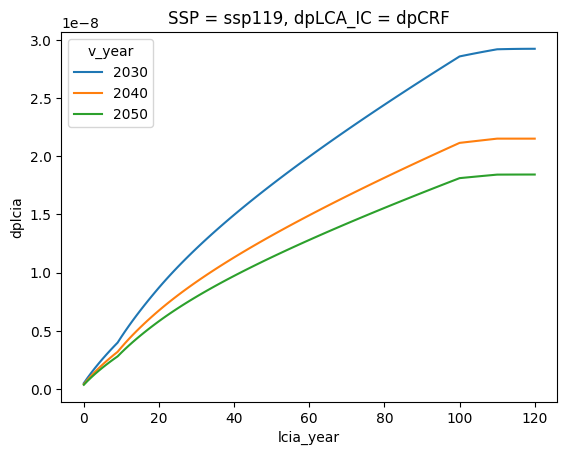

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


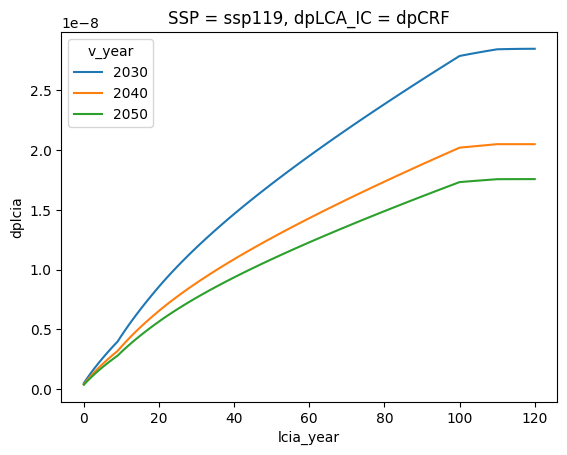

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


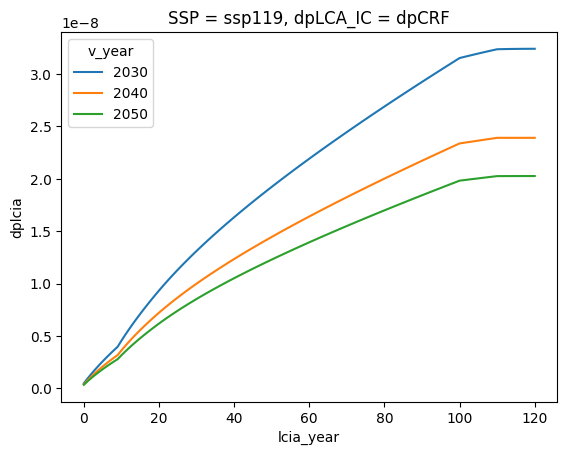

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


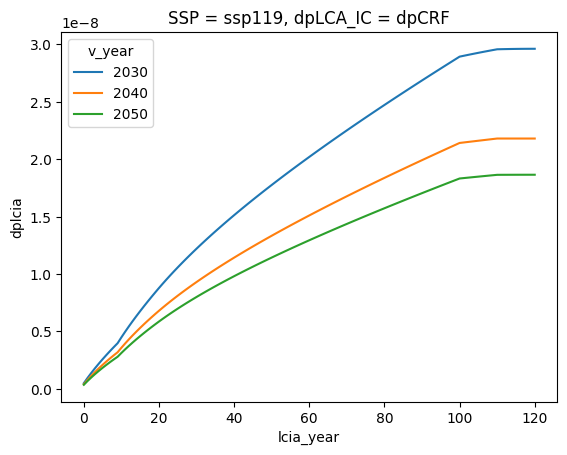

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


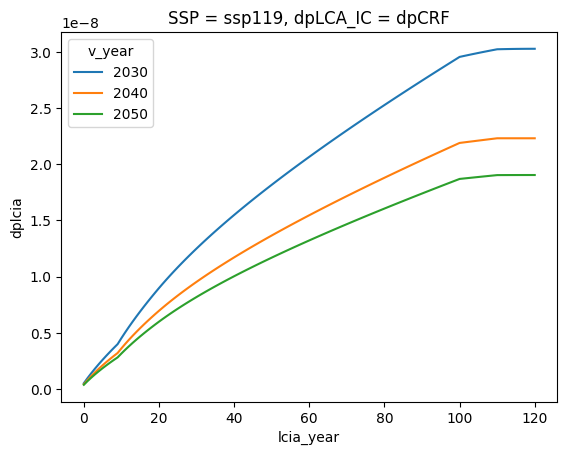

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}


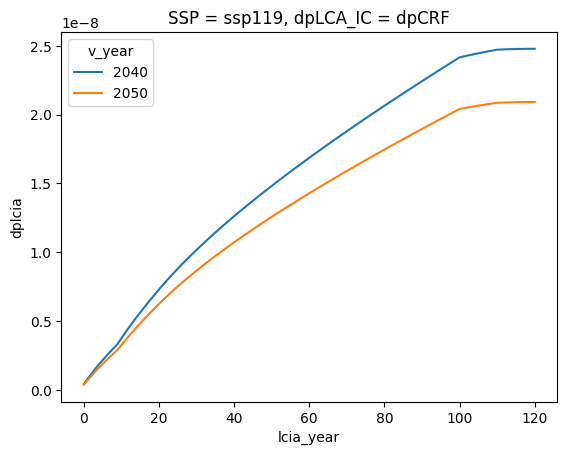

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}


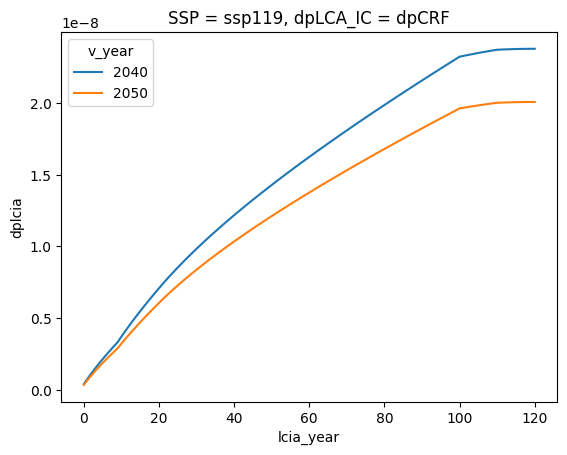

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}


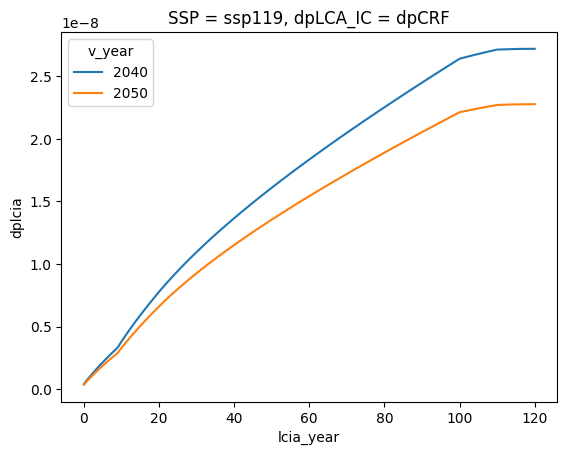

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}


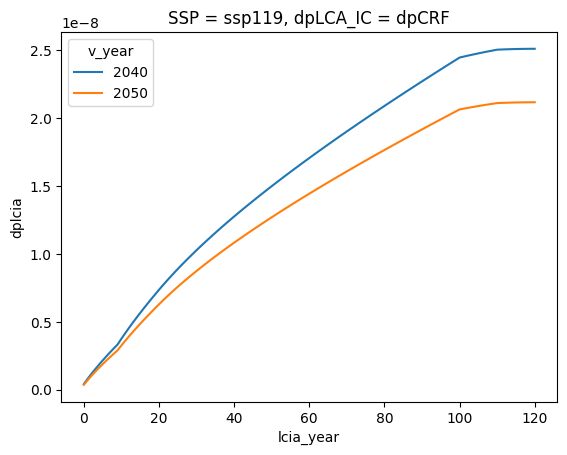

{'V1A_V1B_init': 'LTO', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}


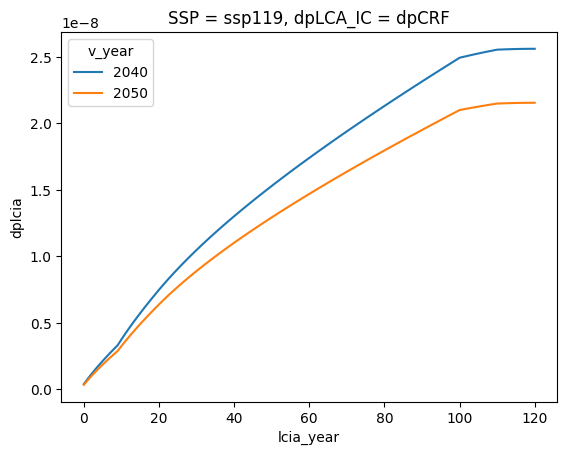

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LFP'}


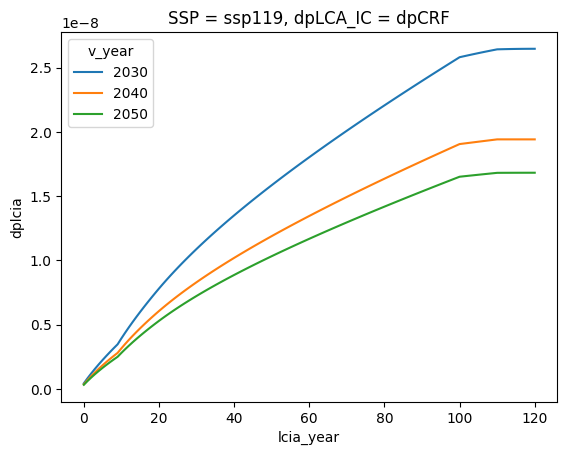

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


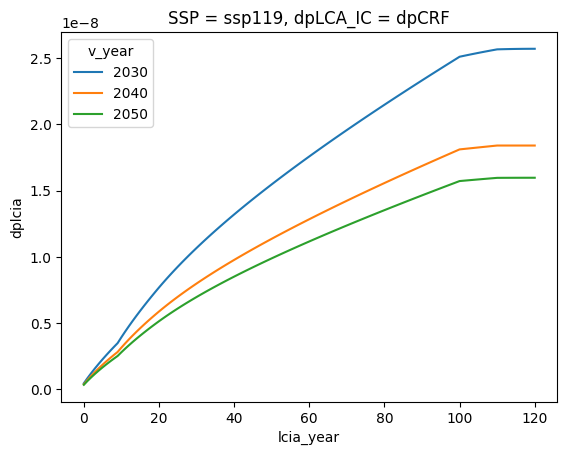

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


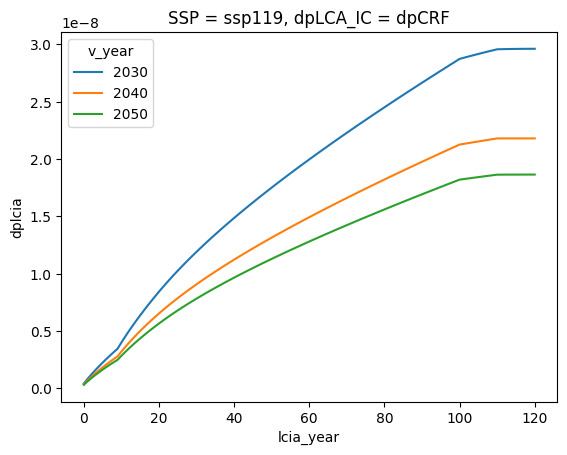

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


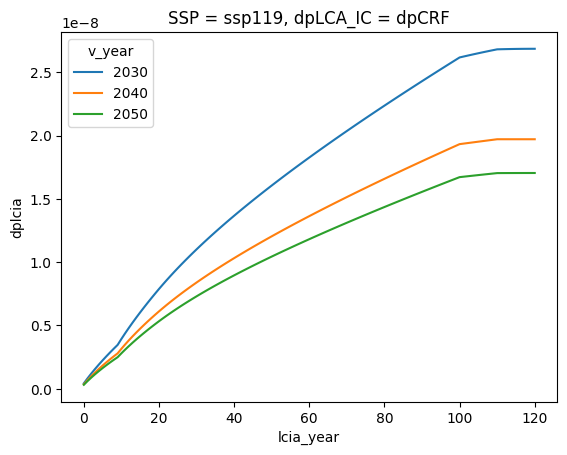

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


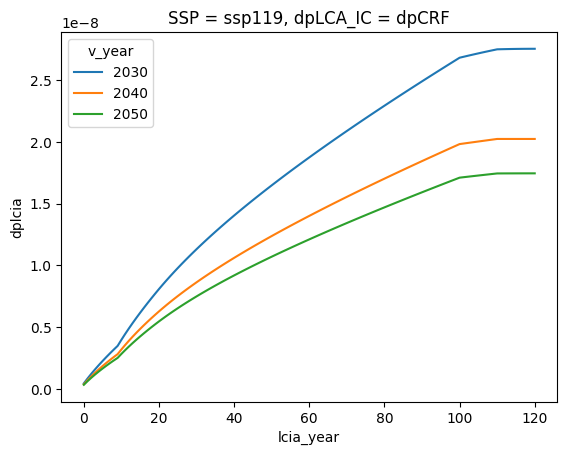

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}


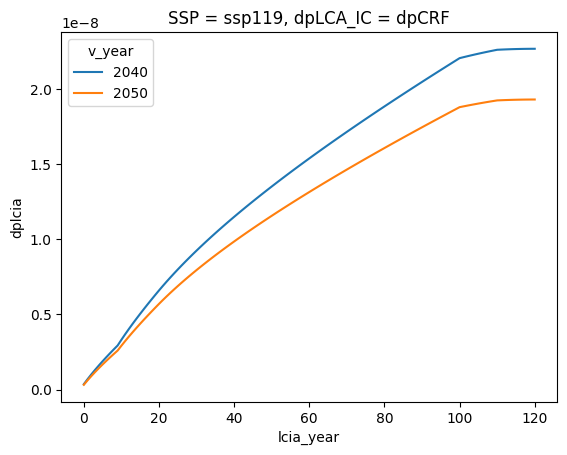

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}


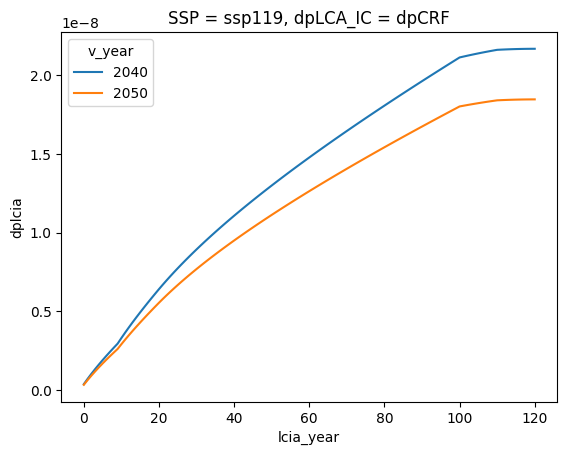

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}


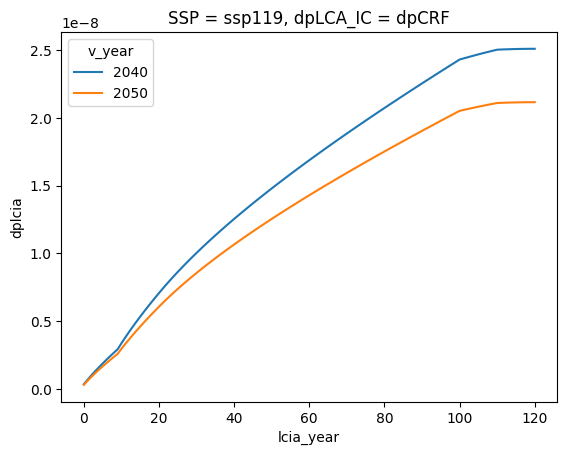

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}


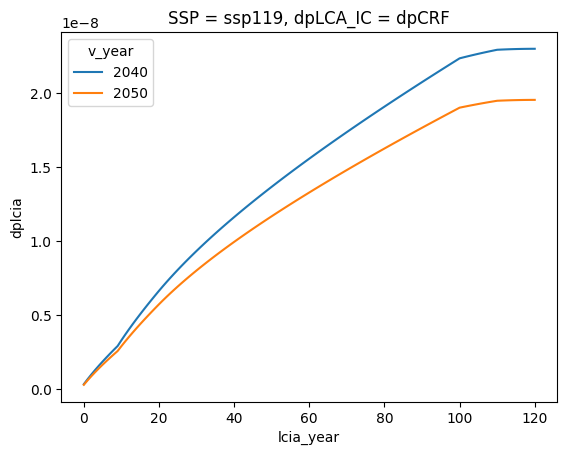

{'V1A_V1B_init': 'NCA', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}


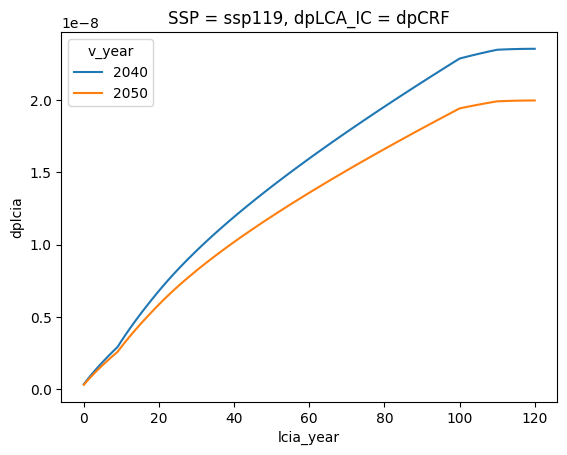

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LFP'}


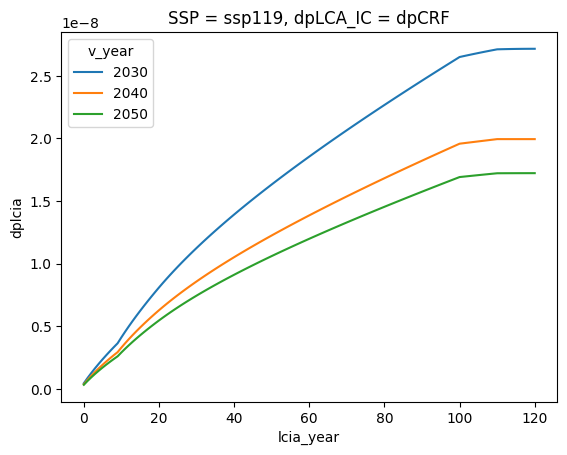

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


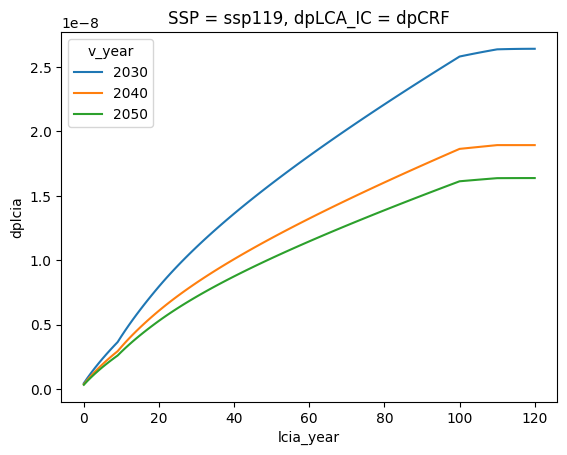

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LTO'}


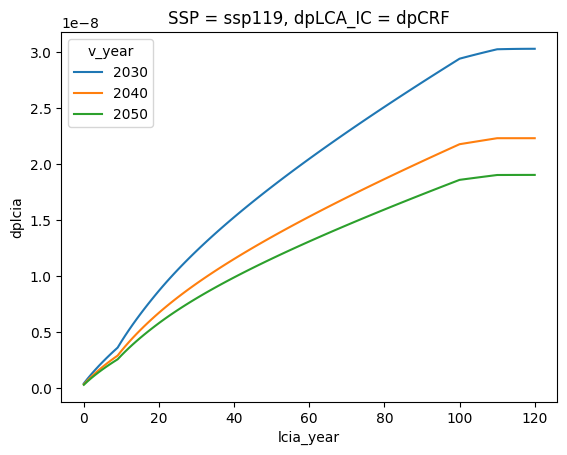

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NCA'}


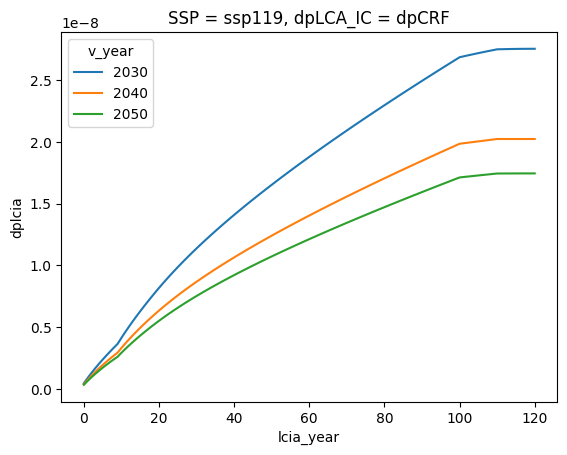

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'grid', 'V1B_repl': 'NMC622'}


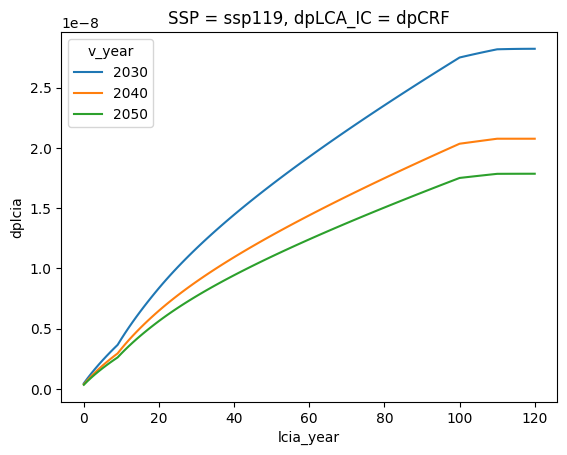

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LFP'}


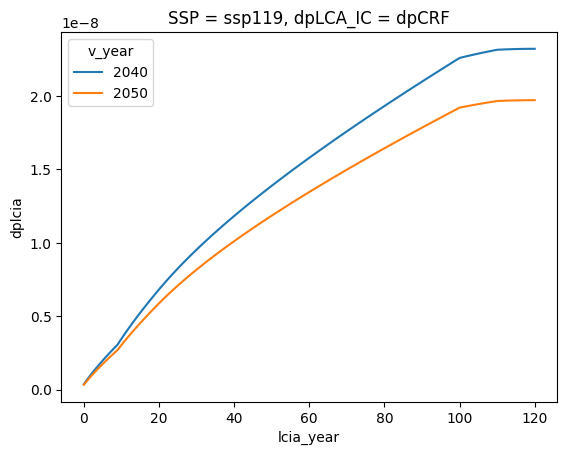

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LSB'}


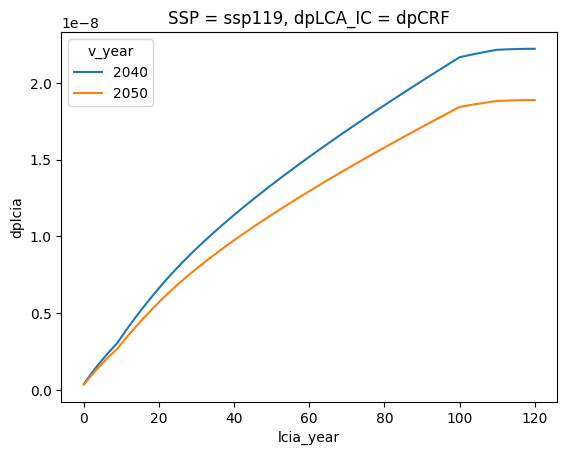

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'LTO'}


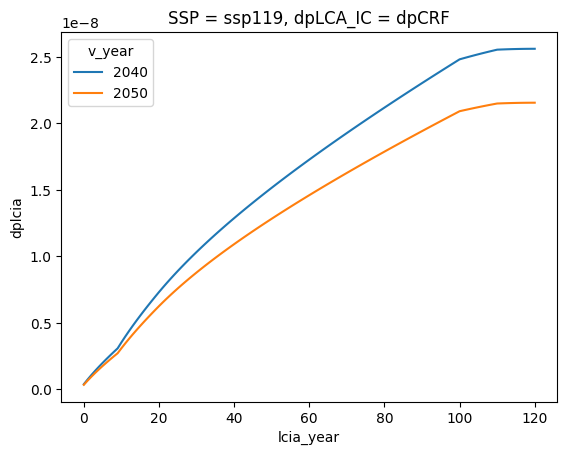

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NCA'}


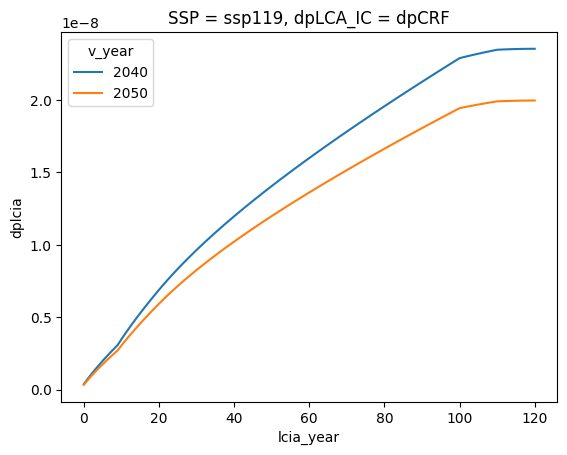

{'V1A_V1B_init': 'NMC622', 'F2_fuel_elec': 'onsite100PV', 'V1B_repl': 'NMC622'}


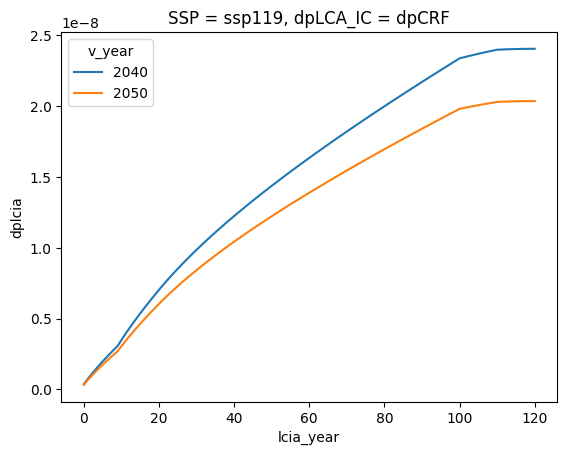

In [17]:
ssp_toplot = "ssp119"

for i in range(len(final_alltech_list)): 
    print(each_tech_toget_formod[i])
    ds_toget = final_alltech_list[i].sel(SSP = ssp_toplot,  dpLCA_IC = 'dpCRF') 
    ds_toplot = ds_toget.where(ds_toget['dplcia'].notnull() , drop = True)
    if len(ds_toplot['dplcia']) == 0: 
        print(f"the module/tech_combination is not available under any SSP[x] for {each_tech_toget_formod[i]}")
    else:
        ds_toplot['dplcia'].plot(x = 'lcia_year', hue = 'v_year'  )
        plt.show()

## export all ds for each tech combination - print(len(allSSPMYlist_veh_cycle), len(each_tech_toget_formod))

In [18]:
print(len(final_alltech_list), len(each_tech_toget_formod))

50 50


In [19]:
combined_ds_techdict = list(zip(each_tech_toget_formod, final_alltech_list))

In [20]:
""" for each combined_ds_techdict[i], the 1st element is the dict for tech_comb, the 2nd element is the ds""" 
print(len(combined_ds_techdict))
print(combined_ds_techdict[1][0])
combined_ds_techdict[1][1]

50
{'V1A_V1B_init': 'LFP', 'F2_fuel_elec': 'grid', 'V1B_repl': 'LSB'}


<xarray.Dataset>
Dimensions:    (SSP: 3, v_year: 3, dpLCA_IC: 3, lcia_year: 121)
Coordinates:
  * SSP        (SSP) object 'ssp119' 'ssp245' 'ssp585'
  * v_year     (v_year) int32 2030 2040 2050
  * dpLCA_IC   (dpLCA_IC) object 'dpIRF' 'dpCRF' 'dpGWP'
  * lcia_year  (lcia_year) int32 0 1 2 3 4 5 6 7 ... 114 115 116 117 118 119 120
Data variables:
    dplcia     (SSP, v_year, dpLCA_IC, lcia_year) float64 4.182e-10 ... nan

In [21]:
import pickle
with open('../dlcia_output/final_allV_mod/BEV_comb_final_ds_50dict.pkl', 'wb') as f:
    pickle.dump(combined_ds_techdict, f)